In [96]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import random_split
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [97]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [98]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [99]:
dataset = torchvision.datasets.ImageFolder("./trafic_32/trafic_32/", transform=transform)
dataloader =torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataset[0][0].size()

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

# testset = torchvision.datasets.ImageFolder("./test_all/", transform=transform)
# testloader =torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [100]:
def get_train_images(num):
    return torch.stack([valset[i][0] for i in range(10,10+num)], dim=0)

In [101]:
image, _ = dataset[0]
print(image.size())

torch.Size([3, 32, 32])


Sieć VAE

In [102]:
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_mean = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_var = nn.Linear(512 * 2 * 2, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.LeakyReLU(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.LeakyReLU(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        
        x = self.LeakyReLU(self.conv4(x))
        x = self.bn4(x)
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)
        
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        
        return mean, log_var


In [103]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_channels):
        super(Decoder, self).__init__()

        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 512 * 2 * 2)
        
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.deconv4 = nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1)
        
        self.leakyrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.leakyrelu(self.fc_1(x))
        x = self.leakyrelu(self.fc_2(x))
        x = self.leakyrelu(self.fc_3(x))
        
        x = x.view(x.size(0), 512, 2, 2)  # Przywrócenie kształtu tensora po spłaszczeniu
        
        x = self.leakyrelu(self.deconv1(x))
        x = self.bn1(x)
        
        x = self.leakyrelu(self.deconv2(x))
        x = self.bn2(x)
        
        x = self.leakyrelu(self.deconv3(x))
        x = self.bn3(x)
        
        x = torch.sigmoid(self.deconv4(x))
        
        return x


In [104]:
class VAE(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_channels=input_channels, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_channels=input_channels)

    def reparameterization(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var


Trening VAE

In [105]:
vae = VAE(input_channels=3, hidden_dim=256, latent_dim=64).to(device)

In [106]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [107]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [108]:
file_path_to_saved_model = "model_vae.pt"

num_epochs = 31
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(trainloader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    if n % 10 == 0:
        torch.save(model, file_path_to_saved_model)

    L1_list = []
    for x, _ in iter(valloader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 45321.149413067025, test L1 = 0.5761017154871932
Epoch 1 loss 41017.994884245985, test L1 = 0.5723264583242618
Epoch 2 loss 40409.41442684442, test L1 = 0.5677456264573384
Epoch 3 loss 39906.91718182578, test L1 = 0.5598004974000822
Epoch 4 loss 39490.962385918385, test L1 = 0.5570546447988448
Epoch 5 loss 39172.02230464768, test L1 = 0.5554009881930623
Epoch 6 loss 38958.743272569445, test L1 = 0.5515786090759727
Epoch 7 loss 38706.92448762822, test L1 = 0.5491569408071719
Epoch 8 loss 38573.20738663513, test L1 = 0.5492153313101792
Epoch 9 loss 38469.76732427848, test L1 = 0.5482573384434227
Epoch 10 loss 38352.8635998025, test L1 = 0.5474404724148231
Epoch 11 loss 38291.62912027746, test L1 = 0.5473180884510521
Epoch 12 loss 38211.932437006246, test L1 = 0.5452278032293164
Epoch 13 loss 38130.19461964832, test L1 = 0.5446620022620612
Epoch 14 loss 38068.536281138506, test L1 = 0.5444308009331789
Epoch 15 loss 38013.056099085756, test L1 = 0.5435732738758491
Epoch 16 los

In [109]:
input_imgs = get_train_images(8)

In [110]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

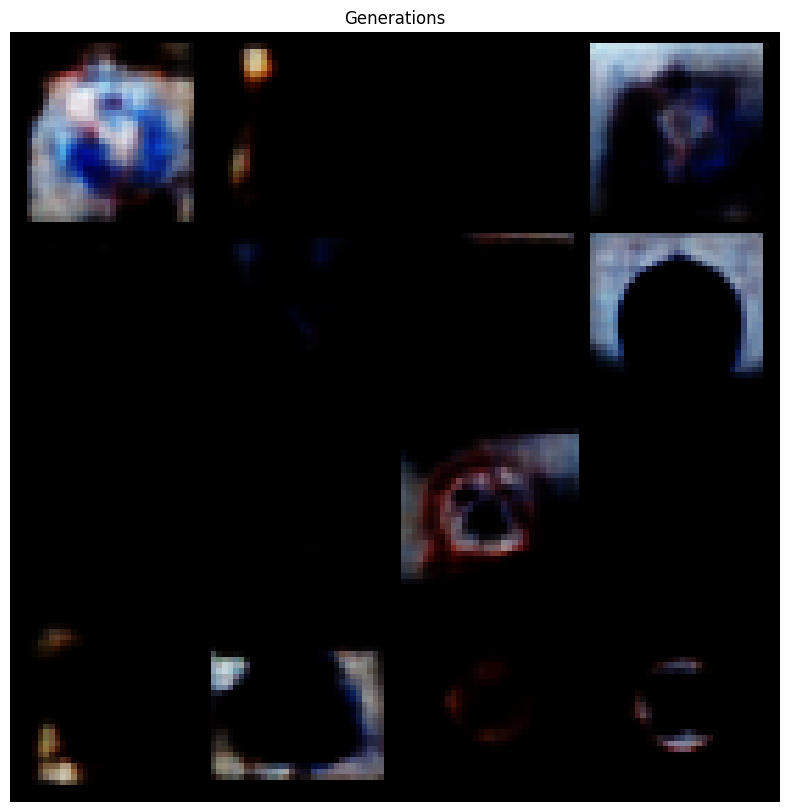

In [111]:
generate_images(vae, 16, device)

Generowanie 1000 obrazków i zapis ich do tensora

In [112]:
vae.eval()
num_images = 1000
generated_images = []

with torch.no_grad():
        generated_imgs = vae.decoder(torch.randn([num_images, vae.latent_dim]).to(device))
        generated_imgs = generated_imgs*0.5+0.5
        generated_images.append(generated_imgs)

generated_images = torch.cat(generated_images, dim=0)
generated_images = generated_images.view(num_images, 3, 32, 32)

torch.save(generated_imgs.cpu().detach(),"poniedzialek_grunwald_rozkosz.pt")

Sieć GLOW

In [113]:
class ActNorm(nn.Module):
    def __init__(self, num_channels):
        super(ActNorm, self).__init__()
        self.num_channels = num_channels
        self.scale = nn.Parameter(torch.ones(1, num_channels, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.initialized = False

    def forward(self, x):
        if not self.initialized:
            self.initialize_parameters(x)
            self.initialized = True
        return (x + self.bias) * self.scale

    def initialize_parameters(self, x):
        with torch.no_grad():
            x_mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
            x_var = torch.var(x, dim=(0, 2, 3), keepdim=True)
            self.scale.data.copy_(1 / torch.sqrt(x_var + 1e-6))
            self.bias.data.copy_(-x_mean * self.scale)


class Invertible1x1Conv(nn.Module):
    def __init__(self, num_channels):
        super(Invertible1x1Conv, self).__init__()
        self.num_channels = num_channels
        self.weight = nn.Parameter(torch.randn(num_channels, num_channels))
        self.register_buffer("inverse_matrix", torch.zeros(num_channels, num_channels))
        self.inverse_initialized = False
        self.log_det_J = None

    def forward(self, x):
        if not self.inverse_initialized:
            self.compute_inverse()
            self.inverse_initialized = True
        return nn.functional.conv2d(x, self.weight.unsqueeze(2).unsqueeze(3))

    def compute_inverse(self):
        self.inverse_matrix = torch.inverse(self.weight.double()).float()
        self.log_det_J = torch.logdet(self.weight.double()).float()

    def apply_inverse(self, z):
        if not self.inverse_initialized:
            self.compute_inverse()
            self.inverse_initialized = True
        return nn.functional.conv2d(z, self.inverse_matrix.unsqueeze(2).unsqueeze(3))


class RevNetBlock(nn.Module):
    def __init__(self, num_channels):
        super(RevNetBlock, self).__init__()
        self.actnorm = ActNorm(num_channels)
        self.invconv = Invertible1x1Conv(num_channels)

    def forward(self, x):
        x = self.actnorm(x)
        x = self.invconv(x)
        return x


class GLOW(nn.Module):
    def __init__(self, num_channels, num_blocks):
        super(GLOW, self).__init__()
        self.num_channels = num_channels
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList([RevNetBlock(num_channels) for _ in range(num_blocks)])

    def forward(self, x):
        log_det_J = 0
        for block in self.blocks:
            x = block(x)
            log_det_J += block.invconv.log_det_J
        return x, log_det_J


In [114]:
input_channels = 3
image_size = 32
num_blocks = 8
num_epochs = 15
batch_size = 64

model = GLOW(input_channels, num_blocks)

def glow_loss_function(log_det_J):
    return -log_det_J.mean()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

for epoch in range(num_epochs):
    losses_epoch = []
    for inputs, _ in iter(trainloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        
        outputs, log_det_J = model(inputs)
        
        loss = glow_loss_function(log_det_J)
        losses_epoch.append(loss.item())
        
        loss.backward(retain_graph=True)
        optimizer.step()

    L1_list = []
    for inputs, _ in iter(valloader):
        inputs  = inputs.to(device)
        outputs, _ = model(inputs)
        L1_list.append(torch.mean(torch.abs(outputs - inputs)).item())

    print(f"Epoch {epoch}, Loss: {np.mean(np.array(losses_epoch))}, Validation L1: {np.mean(L1_list)}")
    scheduler.step()



Epoch 0, Loss: nan, Validation L1: 108.76203809908735
Epoch 1, Loss: nan, Validation L1: 737.894251629589
Epoch 2, Loss: nan, Validation L1: 2640.2374575235012
Epoch 3, Loss: nan, Validation L1: 7333.03470568153
Epoch 4, Loss: nan, Validation L1: 16649.025120680893
Epoch 5, Loss: nan, Validation L1: 32542.66678178989
Epoch 6, Loss: nan, Validation L1: 57439.25365218496
Epoch 7, Loss: nan, Validation L1: 93818.38109756098
Epoch 8, Loss: nan, Validation L1: 144892.60708841463
Epoch 9, Loss: nan, Validation L1: 212972.0231199187
Epoch 10, Loss: nan, Validation L1: 301877.73602642276
Epoch 11, Loss: nan, Validation L1: 414408.65790142276
Epoch 12, Loss: nan, Validation L1: 553606.8502286585
Epoch 13, Loss: nan, Validation L1: 724575.668699187
Epoch 14, Loss: nan, Validation L1: 933854.3404471545


Generowanie obrazkow z modelu GLOW

In [115]:
def generate_images(model, n_imgs, device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_imgs, 3, 32, 32).to(device)
        generated_imgs, _ = model(z)

    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)

    plt.figure(figsize=(10, 10))
    plt.title("Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


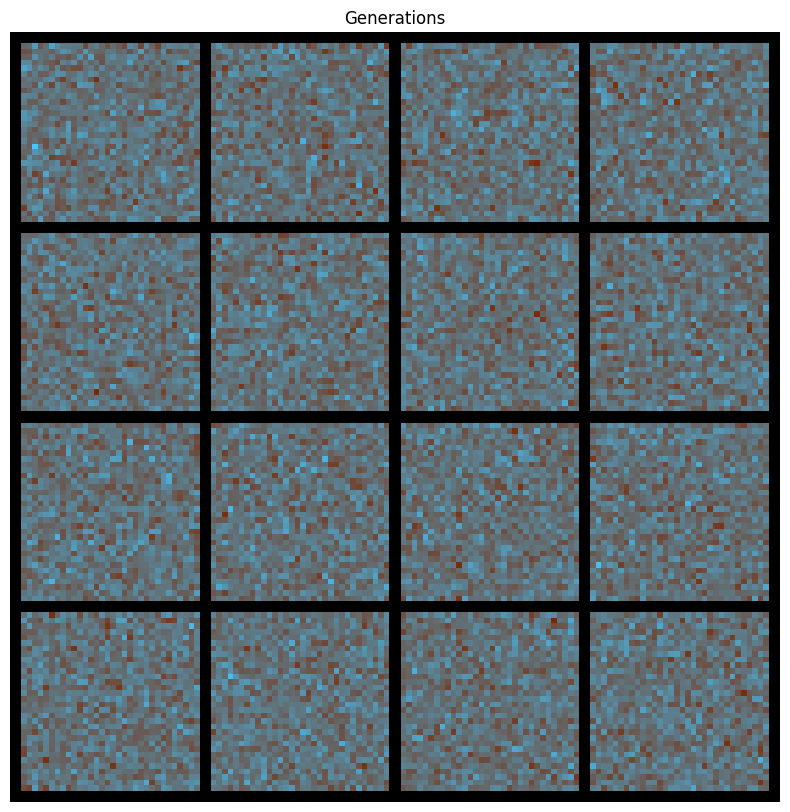

In [116]:
generate_images(model, 16, device)

Ewaluacja

In [117]:
import subprocess
import re

def calculate_fid(dataset1_path, dataset2_path):
    command = f"python -m pytorch_fid {dataset1_path} {dataset2_path}"
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    output = process.communicate()[0]
    output_str = output.decode().strip()

    # wyodrebnienie wartosci FID za pomoca wyrazenia regularnego
    fid_match = re.search(r"FID:\s+(\d+\.\d+)", output_str)
    if fid_match:
        fid_value = float(fid_match.group(1))
        return fid_value
    else:
        raise ValueError("Nie można odnaleźć wartości FID.")


dataset1_path = "real/"
dataset2_path = "generated/"
fid_score = calculate_fid(dataset1_path, dataset2_path)
print("FID score:", fid_score)